# Solution to Exercise set 2: 


**Learning Objectives:**

After completing this exercise set, you will be able to:

- Perform least squares regression with multiple predictor variables
- Perform variable selection by inspecting correlations.
- Explain the distinction between training and testing data.
- Calculate effects from an experimental design.


**To get the exercise approved, complete the following problems:**

- [2.1(b)](#2.1(b)): To show that you can select variables by using information on correlations.

- [2.2(c)](#2.2(c)) and [2.2(e)](#2.2(e)): To show that you can create a linear model with many variables and test it.

- [2.3(a)](#2.3(a)), [2.3(b)](#2.3(b)), and [2.3(c)](#2.3(c)): To show that you can calculate effects from an experimental design.

## Exercise 2.1 Predicting blood pressure

The file [bloodpress.csv](bloodpress.csv) contains data for 20 individuals with high blood pressure.
Your goal is to create a least squares model for predicting blood pressure (BP) that achieves $R^2 > 0.95$, using a maximum of two predictor variables.

The columns present in the data file are:

| Column | Description                                                              |             Unit |
|:-------|:-------------------------------------------------------------------------|-----------------:|
| BP     | Blood pressure                                                           |             mmHg |
| Age    | Age                                                                      |            years |
| Weight | Weight                                                                   |               kg |
| BSA    | Body surface area                                                        |            m$^2$ |
| DUR    | Duration of hypertension                                                 |            years |
| BHR    | Basal heart rate                                                         | beats per minute |
| Stress | Stress index (score derived from a standardized questionnaire)           |              --- |

### 2.1(a)

Before building your model, explore the relationships between the blood pressure and the other variables to identify potential predictor candidates for a linear regression model. Do this by creating scatter plots of BP against the other variables and by calculating the [correlation coefficients](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between BP and the other variables.

**Task:**

1. Calculate the correlation coefficient between BP and each other variable. This can be done with [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html):

```python
import pandas as pd
data = pd.read_csv("bloodpress.csv")
data.corr()
```

2. Create scatter plots of BP against each other variable.

Based on your analysis of the correlations and scatter plots, which of the variables seem most promising for predicting BP?

In [20]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("notebook")

In [21]:
# 1. The correlations:
import pandas as pd

data = pd.read_csv("bloodpress.csv")
data.corr()

,BP,Age,Weight,BSA,Dur,BHR,Stress
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Weight,0.950068,0.407349,1.000000,0.875305,0.200650,0.659340,0.034355
BSA,0.865879,0.378455,0.875305,1.000000,0.130540,0.464819,0.018446
Dur,0.292834,0.343792,0.200650,0.130540,1.000000,0.401514,0.311640
BHR,0.721413,0.618764,0.659340,0.464819,0.401514,1.000000,0.506310
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.506310,1.000000


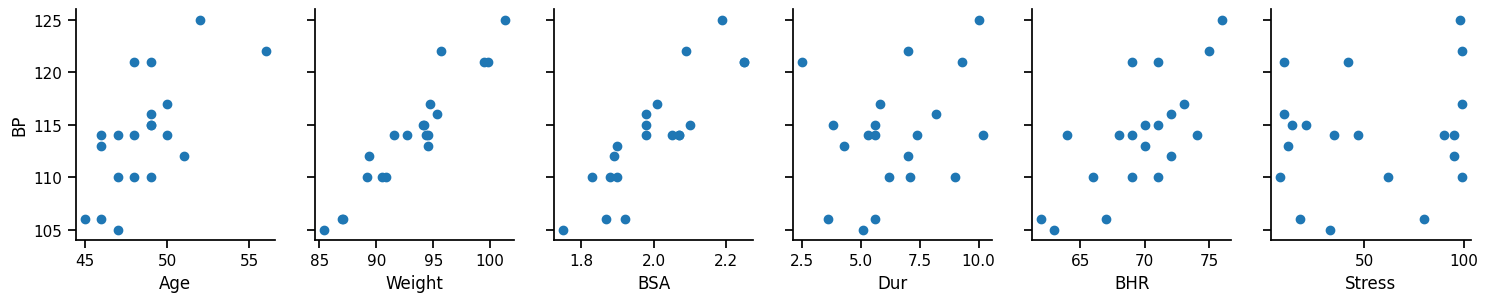

In [22]:
variables = ["Age", "Weight", "BSA", "Dur", "BHR", "Stress"]
fig, axes = plt.subplots(
    ncols=len(variables), figsize=(len(variables) * 3, 3), sharey=True
)
y = data["BP"]
for vari, axi in zip(variables, axes):
    x = data[vari]
    axi.scatter(x, y)
    axi.set(xlabel=vari)
axes[0].set(ylabel="BP")
sns.despine(fig=fig)

#### Your answer to question 2.3(a): Which variables could be most predictive of BP?

The scatter plots and correlation matrix reveal the strongest correlations with BP for Age (0.659), Weight (0.950), and BSA (0.866). The other variables show weeker correlations and they scatter plots appear without a clear linear trend. The most promising variables seem to be Weight and BSA.

### 2.1(b)

**Task:** Construct a least squares model to predict BP. You can use a maximum of two predictor variables, and the model must achieve an R² value of at least 0.95.

In [23]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Pick the two variables with highest correlation:
X = data[["Weight", "BSA"]].to_numpy()
y = data["BP"].to_numpy().reshape(-1, 1)

model_bp = LinearRegression(fit_intercept=True)
model_bp.fit(X, y)
y_hat = model_bp.predict(X)

r2 = r2_score(y, y_hat)
print(f"R² = {r2:.3f}")

R² = 0.908


Well, that did not work as planned. What did we miss? Let us investigate the correlation between weight and BSA:

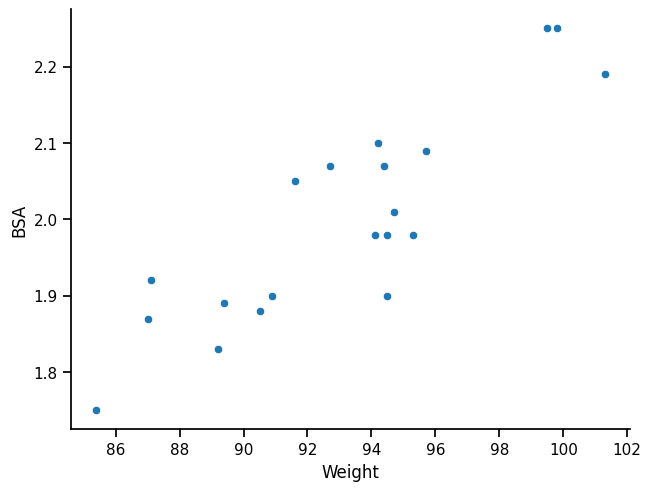

In [24]:
fig, ax = plt.subplots(constrained_layout=True)
sns.scatterplot(data, x="Weight", y="BSA")
sns.despine(fig=fig)

Since Weight and BSA are themselves correlated, using both in the model may not provide substantial additional predictive power. We need to identify a variable that is predictive of BP but independent of Weight. From the correlation matrix we observe that Age is weakly correlated with Weight (0.407). Let us try that:

In [25]:
X = data[["Weight", "Age"]].to_numpy()
y = data["BP"].to_numpy().reshape(-1, 1)

model_bp = LinearRegression(fit_intercept=True)
model_bp.fit(X, y)
y_hat = model_bp.predict(X)

r2 = r2_score(y, y_hat)
print(f"R² = {r2:.3f}")

R² = 0.991


#### Your answer to question 2.1(b): What variables are you using for your prediction

In the final model, I am using Weight and Age.  While BSA showed a strong correlation with BP, it was also highly correlated with Weight (0.875), meaning that it provided redundant information. Age, while having a somewhat weaker correlation with BP, was chosen as it is not correlated with Weight and therefore provides independent information.

## Exercise 2.2: Predicting solubility in water

The dataset [solubility.csv](solubility.csv) contains the measured solubility in water (mol/L) for several molecules. Solubility is a critical property in fields such as drug discovery and environmental chemistry, as it influences how molecules interact with biological systems or the environment. 

In addition to the solubility measurements, we have calculated some molecular descriptors (for instance, the weight of the molecules) using the [RDKit](https://www.rdkit.org/) library. You will use the descriptors to build a predictive least squares model for the solubility.

The raw data is in the following format (showing the first two molecules):

| name                           |   measured log(solubility:mol/L) | SMILES              |   MolWt |   HeavyAtomCount |   RingCount |   LogP    |   MaxPartialCharge |   MinPartialCharge |   NOCount |
|:-------------------------------|---------------------------------:|:--------------------|--------:|-----------------:|------------:|----------:|-------------------:|-------------------:|----------:|
| 1,1,1,2-Tetrachloroethane      |                            -2.18 | ClCC(Cl)(Cl)Cl      | 167.85  |                6 |           0 |    2.5954 |           0.203436 |         -0.122063  |         0 |
| 1,1,1-Trichloroethane          |                            -2    | CC(Cl)(Cl)Cl        | 133.405 |                5 |           0 |    2.3765 |           0.187382 |         -0.0840135 |         0 |


The columns are defined as follows:


| **Column** | **Description** |
|:------------|:-----------------|
| name       | The name of the molecule. |
| measured log(solubility:mol/L) | The logarithm of the measured solubility. The logarithm is used since the solubility can span many orders of magnitude. |
| SMILES     | [SMILES](https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System) (Simplified Molecular Input Line Entry System) - a way to represent molecular structures as text strings. Included if you want to display the molecule. |
| MolWt      | The molecular weight, measured in g/mol. |
| HeavyAtomCount | The number of heavy (non-hydrogen) atoms in the molecule. |
| RingCount  |  The number of rings in the molecule. |
| LogP    | [LogP (octanol-water partition coefficient)](https://en.wikipedia.org/wiki/Octanol-water_partition_coefficient) - a measure of a molecule's lipophilicity (affinity for fatty or oily environments).  A higher LogP indicates greater lipophilicity, while a lower LogP indicates greater hydrophilicity (affinity for water). |
| MaxPartialCharge | The largest charge on any atom in the molecule (atomic units). |
| MinPartialCharge | The smallest charge on any atom in the molecule (atomic units). |
| NOCount          | The number of Nitrogen and Oxygen atoms in the molecule. |


To reiterate, the goal is to predict `measured log(solubility:mol/L)` from `MolWt`, `HeavyAtomCount`, `RingCount`, `LogP`, `MaxPartialCharge`, `MinPartialCharge`, and `NOCount`.


If you want to visualize some of the molecules, you can use the [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html) library. For example:

In [26]:
import numpy as np
import pandas as pd

# RDKit imports for working with molecules:
from rdkit import Chem
from rdkit.Chem import rdCoordGen
from rdkit.Chem.Draw import IPythonConsole

# Draw molecules using svg (instead of png) for better quality:
IPythonConsole.ipython_useSVG = True

data = pd.read_csv("solubility.csv")

Showing SMILES string at index 33: Oc2ccc1ncccc1c2 
Solubility = -2.16


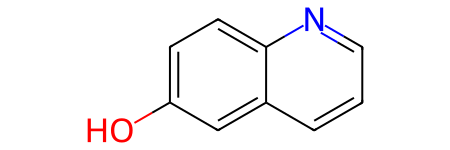

In [27]:
index = 33
smiles_str = data["SMILES"][index]
solubility = data["measured log(solubility:mol/L)"][index]
print(f"Showing SMILES string at index {index}: {smiles_str}")
print(f"Solubility = {solubility}")
# Create a molecule from a smiles string:
mol = Chem.MolFromSmiles(smiles_str)
# Generate 2D coordinates for better visualization (this is not needed):
rdCoordGen.AddCoords(mol)
mol

### 2.2(a)

To predict the solubility $y$, we will make a linear model on the form:

\begin{equation}
\begin{split}
y &= b_0 + b_1 \times (\text{MolWt}) + b_2 \times (\text{HeavyAtomCount}) + b_3 \times (\text{RingCount})\\
&+ b_4 \times (\text{LogP}) + b_5 \times (\text{MaxPartialCharge}) + b_6 \times (\text{MinPartialCharge}) + b_7 \times (\text{NOCount}) .
\end{split}
\end{equation}

This can be expressed in matrix form as:

\begin{equation}
\mathbf{y} = \mathbf{X} \mathbf{b}
\end{equation}

where $\mathbf{y}$ is the vector of measured solubility, $\mathbf{X}$ is the design matrix containing the descriptors, and $\mathbf{b}$ is the vector of coefficients ($b_0$, $b_1$, ..., $b_7$).

The code below attempts to solve for the coefficients $\mathbf{b}$ by directly inverting $\mathbf{X}$:

\begin{equation}
\mathbf{b} =\mathbf{X}^{-1}\mathbf{y}
\end{equation}

However, this approach will fail here.

**Task:** Consider the code below, and do the following:

1. Explain why the code adds a column of ones to $\mathbf{X}$.
2. Explain why inverting $\mathbf{X}$ directly will fail.
3. Correct the code and find $\mathbf{b}$ by using the least squares solution:

\begin{equation}
\mathbf{b} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
\end{equation}

In [28]:
import pandas as pd

data = pd.read_csv("solubility.csv")
data

,name,measured log(solubility:mol/L),SMILES,MolWt,HeavyAtomCount,RingCount,LogP,MaxPartialCharge,MinPartialCharge,NOCount
0,benzhydrol,-2.550,c1ccccc1C(O)c2ccccc2,184.238,14.0,2.0,2.76830,0.104046,-0.383661,1.0
1,Dapsone,-3.094,Nc1ccc(cc1)S(=O)(=O)c2ccc(N)cc2,248.307,17.0,2.0,1.68380,0.206092,-0.398728,4.0
2,Hexamethylbenzene,-5.230,Cc1c(C)c(C)c(C)c(C)c1C,162.276,12.0,1.0,3.53712,-0.039228,-0.044727,0.0
3,Altretamine,-3.364,CN(C)c1nc(nc(n1)N(C)C)N(C)C,210.285,15.0,1.0,0.06960,0.230939,-0.346748,6.0
4,Coumachlor,-5.839,CC(=O)CC(c1ccc(Cl)cc1)c2c(O)c3ccccc3oc2=O,342.778,24.0,3.0,4.26300,0.343366,-0.506592,4.0
...,...,...,...,...,...,...,...,...,...,...
853,Diazinon,-3.640,CCOP(=S)(OCC)Oc1cc(C)nc(n1)C(C)C,304.352,19.0,1.0,3.58472,0.381304,-0.405537,5.0
854,phenothrin,-5.240,CC(C)=CC3C(C(=O)OCc2cccc(Oc1ccccc1)c2)C3(C)C,350.458,26.0,3.0,5.76050,0.309956,-0.460563,3.0
855,Dulcin,-2.170,CCOc1ccc(NC(N)=O)cc1,180.207,13.0,1.0,1.57590,0.316119,-0.493887,4.0
856,Ethyl formate,0.150,CCOC=O,74.079,5.0,0.0,0.17930,0.292565,-0.468195,2.0


In [29]:
# Extract the column with solubility:
y = data["measured log(solubility:mol/L)"].to_numpy().reshape(-1, 1)
# The .reshape(-1, 1) is to reshape y into a column vector.
print(f"Shape of y: {y.shape}")
# Select variables:
descriptors_txt = [
    "MolWt",
    "HeavyAtomCount",
    "RingCount",
    "LogP",
    "MaxPartialCharge",
    "MinPartialCharge",
    "NOCount",
]

# Extract the descriptors:
descriptors = data[descriptors_txt].to_numpy()
# Make a column of ones using np.ones:
ones = np.ones((descriptors.shape[0], 1))
# Add a column of ones to form X:
X = np.hstack((ones, descriptors))
print(f"Shape of X: {X.shape}")

Shape of y: (858, 1)
Shape of X: (858, 8)


In [30]:
# Invert X **this will fail**:
b = np.linalg.inv(X) @ y

LinAlgError: Last 2 dimensions of the array must be square

In [31]:
b = np.linalg.inv(X.T @ X) @ X.T @ y

In [32]:
table_for_b = pd.DataFrame(
    {"Matrix inversion": [i[0] for i in b]}, index=[f"b{i}" for i in range(8)]
)
table_for_b

,Matrix inversion
b0,-0.765535
b1,-0.000850
b2,-0.043783
b3,-0.127031
b4,-0.850612
b5,1.194266
b6,-3.521533
b7,-0.223619


#### Your answer to question 2.2(a):

1. We add the column of ones to be able to also calculate the intercept (the $b_0$ coefficient).
2. The technical reason is that the matrix X is not square; it has more rows (observations) than columns (predictors), and only square matrices are invertible. Another explanation is to say that the problem is overdetermined, meaning there are more equations (data points) than unknowns (coefficients). This implies that there is no single solution that satisfies all equations exactly. No set of coefficients perfectly predicts all the observed solubility values. 
3. See the parameters found above.

### 2.2(b)

The least squares problem from [2.2(a)](#2.2(a)) can also be solved using [numpy.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) function or the [Moore-Penrose pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse), denoted as $\mathbf{X}^+$. The pseudo-inverse is a generalization of the matrix inverse and allows us to calculate the least squares solution b as follows:

\begin{equation}
\mathbf{b} = \mathbf{X}^+  \mathbf{y}
\end{equation}

**Task:** Calculate the least squares solution $\mathbf{b}$ using both [numpy.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) and the pseudo-inverse and compare with the solution you found in [2.2(a)](#2.2(a)).

In [33]:
# 1. First via np.linalg.lstsq:
bnp = np.linalg.lstsq(X, y, rcond=None)[0]
table_for_b["linalg.lstsq"] = [i[0] for i in bnp]
# 2. Then with the pseduinverse:
pinv = np.linalg.pinv(X) @ y
table_for_b["pseudo-inverse"] = [i[0] for i in pinv]
table_for_b

,Matrix inversion,linalg.lstsq,pseudo-inverse
b0,-0.765535,-0.765535,-0.765535
b1,-0.000850,-0.000850,-0.000850
b2,-0.043783,-0.043783,-0.043783
b3,-0.127031,-0.127031,-0.127031
b4,-0.850612,-0.850612,-0.850612
b5,1.194266,1.194266,1.194266
b6,-3.521533,-3.521533,-3.521533
b7,-0.223619,-0.223619,-0.223619


#### Your answer to question 2.2(b): Do you find the same $\mathbf{b}$?

Yes, we get the same values for the parameters (see the table above).

### 2.2(c)

Calculating least squares solutions using matrix operations can be cumbersome, especially remembering to add the column of ones for the intercept. Libraries like [scikit-learn](https://scikit-learn.org) provide more convenient tools for this task. Scikit-learn models are typically created and trained using the `.fit` method of the appropriate model class. The fit method takes two main arguments:

* X: The design matrix. Each row of X represents a single sample and each column represents a variable (feature).
* y: The target variable. The values we want to predict from X.


For least squares regression, here is how we can fit a least squares
model with scikit-learn:
```python
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(X, y)
```

**Task:** Create a least squares model using [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from [scikit-learn](https://scikit-learn.org). Compare the model's intercept and coefficients with the least squares solution you calculated in previous parts of this exercise.  You can access the intercept and coefficients using:

```python
print(model.intercept_)  # b0
print(model.coef_)  #b1, b2, ..., b7
```

**Hint:** When using scikit-learn's `LinearRegression`, the design matrix X should not include a column of ones.
The intercept is handled automatically by setting `fit_intercept=True` (which is the default).

**Note:** You may have noted that we import from `sklearn`, this is the *import name* of the `scikit-learn` package.

In [34]:
from sklearn.linear_model import LinearRegression


X = data[descriptors_txt].to_numpy()

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

print(model.intercept_)
print(model.coef_[0])

[-0.7655354]
[-8.50399244e-04 -4.37825537e-02 -1.27030576e-01 -8.50612123e-01
  1.19426635e+00 -3.52153284e+00 -2.23618886e-01]


In [35]:
table_for_b["scikit-learn"] = [model.intercept_[0]] + [
    i for i in model.coef_[0]
]
table_for_b

,Matrix inversion,linalg.lstsq,pseudo-inverse,scikit-learn
b0,-0.765535,-0.765535,-0.765535,-0.765535
b1,-0.000850,-0.000850,-0.000850,-0.000850
b2,-0.043783,-0.043783,-0.043783,-0.043783
b3,-0.127031,-0.127031,-0.127031,-0.127031
b4,-0.850612,-0.850612,-0.850612,-0.850612
b5,1.194266,1.194266,1.194266,1.194266
b6,-3.521533,-3.521533,-3.521533,-3.521533
b7,-0.223619,-0.223619,-0.223619,-0.223619


#### Your answer to question 2.2(c): What coefficients do you find and what is the intercept?

As shown in the table above, the calculated coefficients remain unchanged from the previous calculations.

### 2.2(d)

A primary purpose of building a predictive model is to *predict* properties for *new* samples. We will now evaluate our solubility model's predictive performance by comparing its predictions (ŷ) to the true measured solubilities (y). With scikit-learn, we can use the `.predict(X)` method to generate predictions from a trained model. This method takes in a design matrix X (containing the feature values for the samples we want to predict) as input:

```python
y_hat = model.predict(X)  # Generate predictions
```

**Task:** Evaluate how well your model is predicting the solubility by:
1. Calculating the [coefficient of determination (R²)](https://en.wikipedia.org/wiki/Coefficient_of_determination).
2. Calculating the [mean absolute error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error).
3. Creating a scatter plot with the true solubilities (y) on the x-axis plotted against the predicted solubilities (ŷ) on the y-axis. For perfect predictions, all scatter points should fall on the $y=x$ line. 

**Hint:** Both R² and the MAE can be calculated with methods from [sklearn.metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html): [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score) and [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)

R² = 0.832
MAE = 0.651


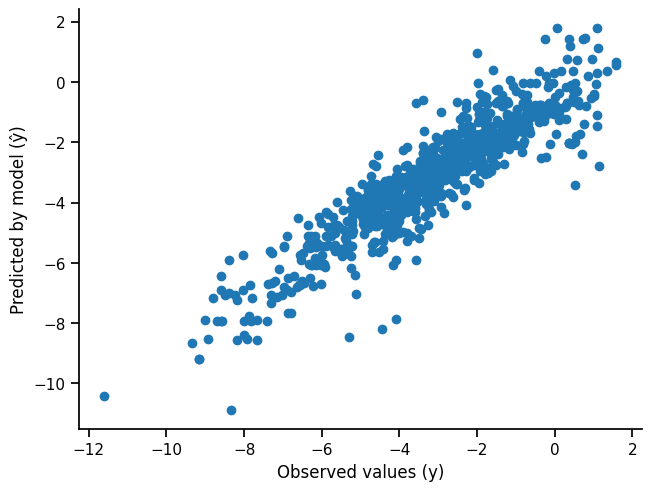

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("notebook")

# 1.+2. We first use the model and then compute R² and MAE
y_hat = model.predict(X)
r2 = r2_score(y, y_hat)
mae = mean_absolute_error(y, y_hat)
print(f"R² = {r2:.3f}")
print(f"MAE = {mae:.3f}")

# 3.
fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(y, y_hat)
ax.set(xlabel="Observed values (y)", ylabel="Predicted by model (ŷ)")
sns.despine(fig=fig)

#### Your answer to question 2.2(d): What values do you get for R² and the MAE?

The R² was 0.832 and the MAE was 0.651.

### 2.2(e)

When we build a predictive model, as you did in [2.2(c)](#2.2(c)), we say that we **train** the model. We refer to the data we used for this process as the **training data** or the **training set**.

In [2.2(d)](#2.2(d)), you evaluated how well your model reproduces the solubility values it was trained on. This, however, does not provide a realistic evaluation of how well the model generalizes to *new, unseen data*. A model could perfectly "memorize" the training data, achieving excellent performance on it, but fail miserably on new samples. This phenomenon, known as **overfitting**, occurs when the model becomes too specific to the training data and loses its ability to generalize.

To assess how well our model is predicting *new* samples and check for overfitting, we must apply it to a set of data that was not part of the training data.
The file [solubility_test.csv](solubility_test.csv) contains data for additional molecules *not* used in training. This data, called the **test set** or **test data** can be used to **test** how well our model is predicting solubilities for new samples.


**Task:** Evaluate how well your model is predicting the test set:

1. Load the data from `solubility_test.csv` into a new design matrix, `X_test`.

2. Use your trained model to predict the solubilities for the molecules in `X_test`.

3. Calculate R² and the MAE using the *test set* predictions and the true values from `solubility_test.csv`.

4. Create a scatter plot of predicted vs. actual solubilities for the *test set*.

5. Compare the test set performance metrics (R², MAE, and the scatter plot) with the training set performance metrics you calculated previously. Note any differences you observe and explain what these differences might suggest about your model's ability to generalize to new data.

In [37]:
# 1.
data_test = pd.read_csv("solubility_test.csv")
X_test = data_test[descriptors_txt].to_numpy()
# 2.
y_test_true = (
    data_test["measured log(solubility:mol/L)"].to_numpy().reshape(-1, 1)
)
y_test_hat = model.predict(X_test)
# 3.
r2_test = r2_score(y_test_true, y_test_hat)
mae_test = mean_absolute_error(y_test_true, y_test_hat)
print(f"R² = {r2_test:.3f}")
print(f"MAE = {mae_test:.3f}")

R² = 0.849
MAE = 0.609


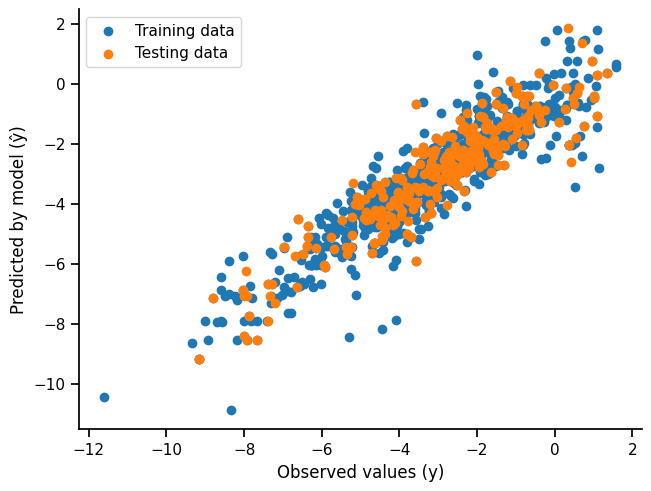

In [38]:
# 4.
fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(y, y_hat, label="Training data")
ax.scatter(y_test_true, y_test_hat, label="Testing data")
ax.set(xlabel="Observed values (y)", ylabel="Predicted by model (ŷ)")
ax.legend()
sns.despine(fig=fig)

#### Your answer to question 2.2(e): What values do you get for R² and the MAE for the test set? Are they significantly different from the training data?

The R² for the training set is 0.83, and for the test set, it is 0.85. The MAE for the training set is 0.65, and for the test set, it is 0.61. The close agreement between training and test set R² and MAE values indicates that the model generalizes well to unseen data and is not overfitting.  The MAE of around 0.61, given that the (logarithmic) solubility values range from -12 to 2, suggests that the model provides reasonably accurate predictions of solubility for many applications.

### Remarks for exercise 2.2

**Remark 1:** The variables you have used in X have different units and they span different ranges. Some modelling methods are sensitive to these differences. We will later in TKJ4175 scale such variables to a common range to address this.

**Remark 2:** Machine learning libraries like scikit-learn provide a consistent interface for predictive models. Most models, including linear regression, implement the `.fit()` and `.predict()` methods. This means you can easily experiment with more advanced models by largely reusing your existing code - simply replace the model instantiation, for example:

```python
from sklearn.linear_model import Lasso  # Use LASSO regression
model2 = Lasso(fit_intercept=True)
model2.fit(X, y)
y_hat = model2.predict(X)
```

In [40]:
# To follow up on Remark 2, here is one example:
from catboost import CatBoostRegressor

model2 = CatBoostRegressor()
model2.fit(X, y)

Learning rate set to 0.039964
0:	learn: 2.0631949	total: 145ms	remaining: 2m 25s
1:	learn: 2.0024412	total: 146ms	remaining: 1m 13s
2:	learn: 1.9483987	total: 147ms	remaining: 49s
3:	learn: 1.8963724	total: 148ms	remaining: 36.9s
4:	learn: 1.8444251	total: 149ms	remaining: 29.7s
5:	learn: 1.7963162	total: 150ms	remaining: 24.8s
6:	learn: 1.7504674	total: 151ms	remaining: 21.4s
7:	learn: 1.7070619	total: 151ms	remaining: 18.8s
8:	learn: 1.6629471	total: 152ms	remaining: 16.8s
9:	learn: 1.6200102	total: 153ms	remaining: 15.2s
10:	learn: 1.5818594	total: 154ms	remaining: 13.8s
11:	learn: 1.5445183	total: 155ms	remaining: 12.7s
12:	learn: 1.5100268	total: 156ms	remaining: 11.8s
13:	learn: 1.4757570	total: 156ms	remaining: 11s
14:	learn: 1.4410690	total: 158ms	remaining: 10.4s
15:	learn: 1.4089137	total: 159ms	remaining: 9.77s
16:	learn: 1.3773176	total: 160ms	remaining: 9.23s
17:	learn: 1.3487258	total: 161ms	remaining: 8.76s
18:	learn: 1.3219577	total: 161ms	remaining: 8.34s
19:	learn: 1.

R² = 0.966
MAE = 0.257


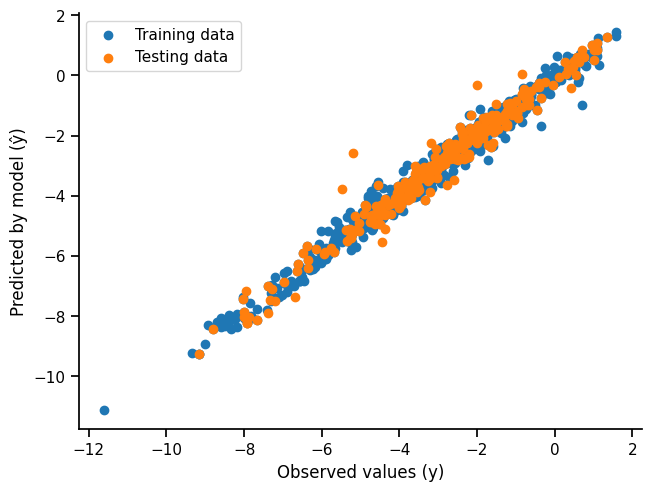

In [41]:
y_hat_2 = model2.predict(X)
y_test_hat_2 = model2.predict(X_test)
r2_test2 = r2_score(y_test_true, y_test_hat_2)
mae_test2 = mean_absolute_error(y_test_true, y_test_hat_2)
print(f"R² = {r2_test2:.3f}")
print(f"MAE = {mae_test2:.3f}")

fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(y, y_hat_2, label="Training data")
ax.scatter(y_test_true, y_test_hat_2, label="Testing data")
ax.set(xlabel="Observed values (y)", ylabel="Predicted by model (ŷ)")
ax.legend()
sns.despine(fig=fig)

## Exercise 2.3 Analyzing an experimental design

The growth rate of a particular bacterium species depends on the concentration of nutrients such as phosphate ($P$),
sucrose ($S$), and nitrate ($N$). The table below displays the experimental design used to investigate how these three concentrations influence the growth rate.


|$P$  | $S$ | $N$ | $PS$ | $PN$ | $SN$ | $PSN$ | **Growth rate**  |
|:---:|:---:|:---:|:----:|:----:|:----:|:-----:|:----------------:|
| $+$ | $-$ | $-$ | $-$  | $-$  | $+$  | $+$   | $7$              |  
| $-$ | $+$ | $-$ | $-$  | $+$  | $-$  | $+$   | $10$             | 
| $+$ | $-$ | $+$ | $-$  | $+$  | $-$  | $-$   | $8$              | 
| $-$ | $+$ | $+$ | $-$  | $-$  | $+$  | $-$   | $11$             |  
| $-$ | $-$ | $-$ | $+$  | $+$  | $+$  | $-$   | $11$             |
| $+$ | $+$ | $+$ | $+$  | $+$  | $+$  | $+$   | $12$             |
| $+$ | $+$ | $-$ | $+$  | $-$  | $-$  | $-$   | $7$              |
| $-$ | $-$ | $+$ | $+$  | $-$  | $-$  | $+$   | $7$              | 

### 2.3(a)
Use the information in the table and compute the main effects.

In [42]:
import numpy as np

y = np.array([7, 10, 8, 11, 11, 12, 7, 7])
P = np.array([1, -1, +1, -1, -1, 1, 1, -1])
S = np.array([-1, 1, -1, 1, -1, 1, 1, -1])
N = np.array([-1, -1, 1, 1, -1, 1, -1, 1])

effect_P = np.dot(P, y) / 4
effect_S = np.dot(S, y) / 4
effect_N = np.dot(N, y) / 4

print(f"Effect(P): {effect_P}")
print(f"Effect(S): {effect_S}")
print(f"Effect(N): {effect_N}")

Effect(P): -1.25
Effect(S): 1.75
Effect(N): 0.75


#### Your answer to question 2.3(a): What are the main effects?
The effects are:

- Effect(P): -1.25
- Effect(S): 1.75
- Effect(N): 0.75

### 2.3(b)
Verify that the columns for the 2-factor and 3-factor interaction effects are correct in table 2 and compute the interaction effects.

In [43]:
import pandas as pd

# Multiply for the new columns:
PS = P * S
PN = P * N
SN = S * N
PSN = P * S * N

# Let us try to print this out:
design = np.column_stack((P, S, N, PS, PN, SN, PSN, y))
design = pd.DataFrame(
    design, columns=["P", "S", "N", "PS", "PN", "SN", "PSN", "Growth rate"]
)
design

,P,S,N,PS,PN,SN,PSN,Growth rate
0,1,-1,-1,-1,-1,1,1,7
1,-1,1,-1,-1,1,-1,1,10
2,1,-1,1,-1,1,-1,-1,8
3,-1,1,1,-1,-1,1,-1,11
4,-1,-1,-1,1,1,1,-1,11
5,1,1,1,1,1,1,1,12
6,1,1,-1,1,-1,-1,-1,7
7,-1,-1,1,1,-1,-1,1,7


In [ ]:
# Calculate the remaining effects:
effect_PS = np.dot(PS, y) / 4
effect_PN = np.dot(PN, y) / 4
effect_SN = np.dot(SN, y) / 4
effect_PSN = np.dot(PSN, y) / 4

print(f"Effect(PS): {effect_PS}")
print(f"Effect(PN): {effect_PN}")
print(f"Effect(SN): {effect_SN}")
print(f"Effect(PSN): {effect_PSN}")

Effect(PS): 0.25
Effect(PN): 2.25
Effect(SN): 2.25
Effect(PSN): -0.25


#### Your answer to question 2.3(b): What are the interaction effects?

The interaction effects are:

- Effect(PS): 0.25
- Effect(PN): 2.25
- Effect(SN): 2.25
- Effect(PSN): -0.25

### 2.3(c)
What factors and interactions seem to increase the growth rate?

#### Your answer to question 2.3(c):

The growth rate is increased by the factors S and N and the interactions PS, PN and SN.